In [1]:
import random
import numpy.random as rnd

from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle
import json

from scipy.integrate import odeint
import scipy.special as sps
import scipy.optimize as spo
from scipy.integrate import odeint
#import interp1d
import scipy.optimize as so
from scipy.interpolate import interp1d

# from jupyter_server import serverapp as app; 
# import ipykernel, requests;

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')


plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [2]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [3]:
import analysis.mathematical_functions.funcs as funcs

In [4]:
data_folder = project_path+'/data/parameter_runs/many_kappas/'
data_files = os.listdir(data_folder)
data_files = [data_folder+'/'+f for f in data_files if f.endswith('_feather')]
dataframes = [pd.read_feather(f) for f in data_files]

In [5]:
data_files

['../data/parameter_runs/many_kappas//01-10-19--04-06-2023abm_result_feather']

In [6]:
if len(dataframes)==1:
    datadf = dataframes[0]

In [7]:
datadf['first_tb'].unique()

array([29.47310585, 20.68064554,         inf, ..., 10.84717367,
        5.99631146,  3.10555556])

In [254]:


def find_x_inf(R0,k):
    if k>0:
        c = (R0-k+R0*k)/(k*(R0-k))
        rho = 1/(R0/k)
        y_x = lambda x: c*x**rho + x/(rho-1) - 1/k

        roots = so.fsolve(y_x, 0)
        return roots[0]
    else:
        return np.real(-1/R0*sps.lambertw(-R0*np.exp(-R0)))

def model_w_params(R0, N, k, control_fun): 
    def model(X,t):
        S = X[0]
        I = X[1]
        y = I/N
        x= S/N

        R0_eff = R0 * control_fun(y,x,k)
        dSdt = - R0_eff * S*y
        dIdt = I *  (R0_eff * x - 1)
        return [dSdt,dIdt]
    return model

def integrate_trajectory(R0,kappa,N, I0=10, Nsteps = int(1e4), control_fun = lambda y,k: 1/(1+k*y)):
    S0 = N-I0
    y0 = [S0,I0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = .45*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,Nsteps)
    dt = ts[1]-ts[0]
    X = odeint(model_w_params(R0,N,kappa,control_fun=control_fun),y0,ts).T

    return ts, X


def vacc_model_w_params(R0, N, kappa,v,t0,vlim, control_fun = lambda y,k: 1/(1+k*y)): 
    def model(y,t):
        S = y[0]
        I = y[1]
        V = y[2]
        R0_eff = R0*control_fun(I/N,S/N,kappa)
        dVdt = v*np.heaviside(t-t0,1)*(1-V/(vlim*N))
        dSdt = - R0_eff * S*I/N - dVdt
        dIdt =  R0_eff * S*I/N -I
        return [dSdt,dIdt,dVdt]
    return model

def vacc_integrate_trajectory(R0,kappa,v, t0, N,I0 = 10, Nsteps = int(1e4), vlim = 1/2, control_fun = lambda y,k: 1/(1+k*y)):
    S0 = N-I0
    y0 = [S0,I0,0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = .45*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,Nsteps)
    dt = ts[1]-ts[0]

    solution  = odeint(vacc_model_w_params(R0,N,kappa,v,t0,vlim, control_fun=control_fun),y0,ts).T

    return ts, solution

In [255]:

@jit(nopython=True)
def p_surv(fit,t_lim,dt,reg= 1e-1):
    L = len(fit)
    pi_ext_ode_hand_inv_t = np.zeros(L)
    pi_ext_ode_hand_inv_t[-1] = np.minimum(1/(1+fit[-1]),1-reg)
    for i in range(L-1):
        pi_ext= pi_ext_ode_hand_inv_t[L-1-i]
        pi_ext_ode_hand_inv_t[L-2-i] = pi_ext -dt * (1-pi_ext)*(-1+pi_ext*(1+fit[L-2-i]))
    p_surv = 1-pi_ext_ode_hand_inv_t
    return p_surv
            

def product_sum_probas(S,I,R, v_t, t_lim, R0, kappa,xi,ds,dt, N, p_alpha, control_fun = lambda y,x,k: 1/(1+k*y)):
    x,y = S/N, I/N
    z = R/N
    
    fit_d = lambda d: R0 * control_fun(y,x,kappa) * ( x + (1- np.exp(-d/xi))*(z+ v_t) )-1

    product_sum = 0
    
    L = len(ds)
    for i in range(L):
        d= ds[i]
        fit = fit_d(d)
        p_surv_t = p_surv(fit,t_lim, dt)
        product_sum +=funcs.rho_d(d=d,p_alpha=p_alpha )*p_surv_t
    
    return product_sum

def product_sum_probas_adiabatic(S,I,R, v_t, t_lim, R0, kappa,xi,ds,dt, N, p_alpha, control_fun = lambda y,x,k: 1/(1+k*y)):
    x,y = S/N, I/N
    z = R/N
    
    fit_d = lambda d: R0*control_fun(y,x,kappa) * ( x + (1- np.exp(-d/xi))*(z+ v_t) )-1

    product_sum = 0
    
    L = len(ds)
    for i in range(L):
        d= ds[i]
        fit = fit_d(d)
        p_surv_t = np.maximum(0,1 - 1/(1+fit))
        product_sum +=funcs.rho_d(d=d,p_alpha=p_alpha )*p_surv_t
    
    return product_sum

In [256]:
R0= 3
kappa = 3e3

p_alpha =.1
xi = 50
ds = np.arange(1,10/p_alpha,1)

vlim = .3

t0 = 50
N = 1e8
v = N/24

yc = 4e-4

fractional_fun = lambda y,x,k: 1/(1+k*y)
exp_fun = lambda y,x,k: np.exp(-k*y)
linear_fun = lambda y,x,k: 1-k*y
constant_y_fun = lambda y,x,k: np.abs(np.minimum(1/(R0*x), 1)) if k*y>=1 else 1

fractional_Gamma = lambda yc, R0: (R0-1)/(yc)
exponential_Gamma = lambda yc, R0: np.log(R0)/yc
linear_Gamma = lambda yc, R0: (R0-1)/(R0*yc)
constant_y_Gamma = lambda yc, R0: 1/yc

#vectorize the constant_y_fun
constant_y_fun = np.vectorize(constant_y_fun, otypes=[float])

control_funs = [fractional_fun, exp_fun, linear_fun, constant_y_fun]
control_yp_funcs = [fractional_Gamma, exponential_Gamma, linear_Gamma, constant_y_Gamma]

control_labels = ['Fractional','Exponential','Linear', 'Constant infected fraction']
control_colors = ['steelblue','darkorange','forestgreen','firebrick']

controlled_trajectories_v0 = {}
controlled_trajectories_v = {}

for i,control_fun in tqdm(enumerate(control_funs)):
    kappa = control_yp_funcs[i](yc,R0)
    ts, (S,I,V) = vacc_integrate_trajectory(R0,kappa,v,t0,N, Nsteps = int(1e4),vlim=vlim, control_fun = control_fun)
    x,y= S/N,I/N
    R = np.cumsum(I)*ts[1]

    z_v = V/N
    ts_v0, (S_v0,I_v0) = integrate_trajectory(R0,kappa,N, Nsteps = int(1e4), control_fun = control_fun)
    x_v0,y_v0= S_v0/N,I_v0/N
    R_v0 = np.cumsum(I_v0)*ts_v0[1]

    psum_v0 = product_sum_probas(S_v0,I_v0,R_v0,0, t_lim=ts[-1], R0=R0, kappa=kappa,xi=xi,ds=ds,dt=ts[1], N=N, p_alpha=p_alpha, control_fun = control_fun)
    
    psum_v = product_sum_probas(S,I,R,z_v, t_lim=ts[-1], R0=R0, kappa=kappa,xi=xi,ds=ds,dt=ts[1], N=N, p_alpha=p_alpha, control_fun = control_fun)

    controlled_trajectories_v0[control_labels[i]] = {'ts':ts_v0,'x':x_v0,'y':y_v0,'psum':psum_v0}
    controlled_trajectories_v[control_labels[i]] = {'ts':ts,'x':x,'y':y,'z':z_v,'psum':psum_v}





1it [00:00,  9.22it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2204964814604D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2163604298747D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.8322431199949D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.8322431199949D-15
 lsoda--  warning..internal t (=r1) 

4it [00:00,  5.60it/s]


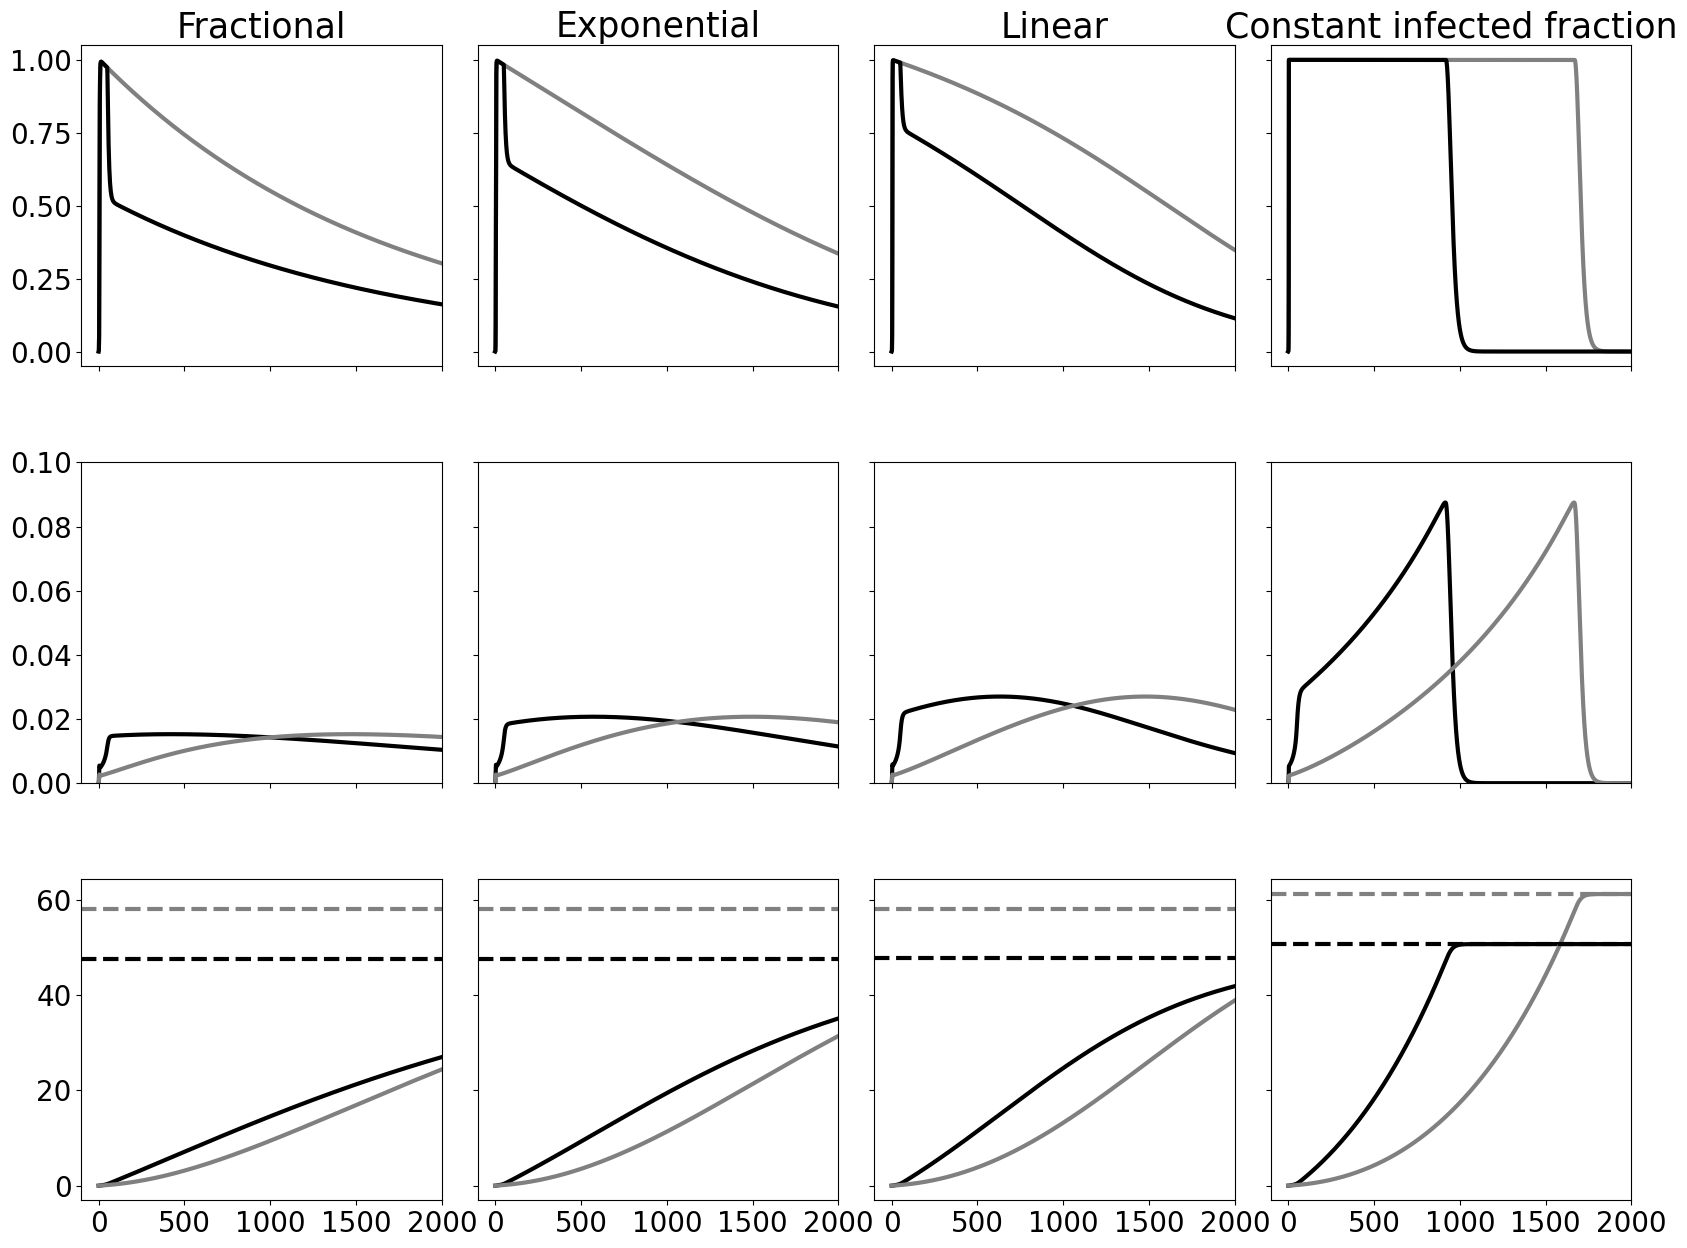

In [296]:
fig,ax= plt.subplots(3,4,figsize=(20,15),sharex=True,sharey='row')

mu = 1e-4
N=  1e7

T = 0
delta= 1/(p_alpha*xi)

plt.subplots_adjust(wspace=0.1,hspace=0.3)

for i,control_label in enumerate(control_labels):
    ts_v0 = controlled_trajectories_v0[control_label]['ts']

    y_v0 = controlled_trajectories_v0[control_label]['y']
    psum_v0 = controlled_trajectories_v0[control_label]['psum']

    ts = controlled_trajectories_v[control_label]['ts']
    y_v = controlled_trajectories_v[control_label]['y']
    psum_v = controlled_trajectories_v[control_label]['psum']

    ax[0,i].plot(ts_v0,y_v0/yc,label='y',color='grey')
    ax[0,i].plot(ts,y_v/yc,label='y',color='black')
    
    eps = mu*N*y_v*psum_v
    eps_v0 = mu*N*y_v0*psum_v0

    ax[1,i].plot(ts, eps,label='eps',color='black')
    ax[1,i].plot(ts_v0, eps_v0,label='eps',color='grey')

    c_eps = np.cumsum(eps)*ts[1]
    c_eps_v0 = np.cumsum(eps_v0)*ts[1]

    ax[2,i].plot(ts, c_eps,label='c_eps',color='black')
    ax[2,i].plot(ts_v0, c_eps_v0,label='c_eps',color='grey')   

    ax[2,i].axhline(c_eps[-1],color='black',linestyle='--')
    ax[2,i].axhline(c_eps_v0[-1],color='grey',linestyle='--')

    # ax[2,i].axhline(mu*N*(1-1/R0)**2/2*delta/(1-delta),color='grey',linestyle=':')
    
for i,a in enumerate(ax[0,:]):
    a.set_title(control_labels[i],fontsize=25)
    a.set_xlim(-100,2000)
    a.tick_params(axis='both',labelsize=20)

for i,a in enumerate(ax[1,:]):
    a.set_ylim(0,.1)
    a.tick_params(axis='both',labelsize=20)

for i,a in enumerate(ax[2,:]):
    a.tick_params(axis='both',labelsize=20)
    a.set_xticks(np.arange(0,5)*500)

plt.savefig(output_folder+'SI_vaccination_trajectories_emergence.svg',bbox_inches='tight')
    

In [258]:
kappa = control_yp_funcs[i](yc,R0)
ts, (S,I,V) = vacc_integrate_trajectory(R0,kappa,v,t0,N, Nsteps = int(1e5),vlim=vlim, control_fun = control_fun)
x,y= S/N,I/N
z_v = V/N
R = np.cumsum(I)*ts[1]
z= R/N
a_t= constant_y_fun(y,x,kappa)

ts_v0, (S_v0,I_v0) = integrate_trajectory(R0,kappa,N, Nsteps = int(1e5), control_fun = control_fun)
x_v0,y_v0= S_v0/N,I_v0/N
R_v0 = np.cumsum(I_v0)*ts_v0[1]
z_v0 = R_v0/N

psum_v0 = product_sum_probas(S_v0,I_v0,R_v0,0, t_lim=ts[-1], R0=R0, kappa=kappa,xi=xi,ds=ds,dt=ts[1], N=N, p_alpha=p_alpha, control_fun = control_fun)

psum_v = product_sum_probas(S,I,R,z_v, t_lim=ts[-1], R0=R0, kappa=kappa,xi=xi,ds=ds,dt=ts[1], N=N, p_alpha=p_alpha, control_fun = control_fun)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2820710663082D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2820710663082D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2820710663082D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2820710663082D-14


2500.0 0.0004


(0.0, 0.6666666666666667)

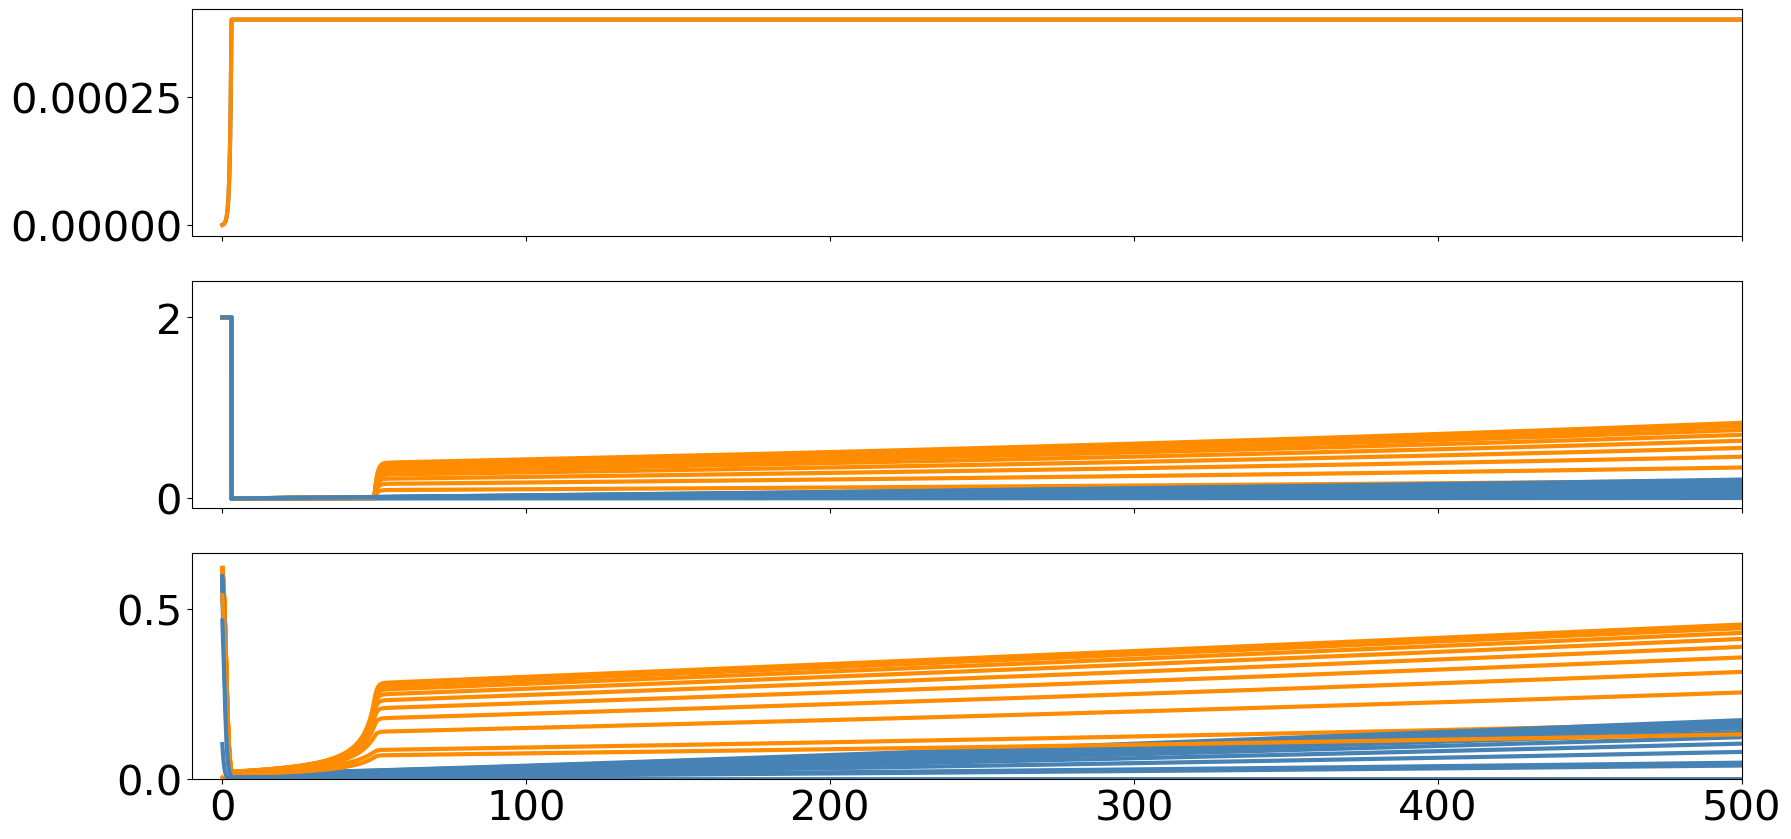

In [259]:
fig,ax = plt.subplots(3,1,figsize=(20,10),sharex=True)
ax[0].plot(ts_v0,y_v0,label='y',color='steelblue')
ax[0].plot(ts,y,label='y',color='darkorange')

for d in ds[::10]:
    fd = np.minimum(R0*control_fun(y,x,kappa) * ( x + (1- np.exp(-d/xi))*(z + z_v) )-1,R0-1)
    fd_v0 = np.minimum(R0*control_fun(y_v0,x_v0,kappa) * ( x_v0 + (1- np.exp(-d/xi))*(z_v0) )-1,R0-1)

    pi_td = p_surv(fd,ts[-1],ts[1])
    pi_td_v0 = p_surv(fd_v0,ts_v0[-1],ts_v0[1])

    ax[1].plot(ts,fd,label='fd',color='darkorange')
    ax[1].plot(ts_v0,fd_v0,label='fd',color='steelblue')

    # ax[2].plot(ts, fd/(1+fd),label='fd',color='darkorange')
    # ax[2].plot(ts_v0, fd_v0/(1+fd_v0),label='fd',color='steelblue')

    ax[2].plot(ts, pi_td,label='pi_td',color='darkorange')
    ax[2].plot(ts_v0, pi_td_v0,label='pi_td',color='steelblue')

print(kappa,yc)

cfun = constant_y_fun(y,x,kappa)
cfun_v0 = constant_y_fun(y_v0,x_v0,kappa)

# for d in ds[::5]:
#     c_d =np.exp(-d/xi)
#     ax[1].plot(ts, R0*cfun*(x + c_d*(z+ z_v)),label='x',color='darkorange')
#     ax[1].plot(ts_v0, R0*cfun_v0*(x_v0+ c_d*(z_v0)),label='x',color='steelblue')

ax[2].plot(ts, psum_v,label='psum',color='darkorange')
ax[2].plot(ts_v0, psum_v0,label='psum',color='steelblue')

for a in ax:
    a.set_xlim(-10,500)

ax[1].set_ylim(-.1,R0-.6)
ax[2].set_ylim(0, 1-1/R0)

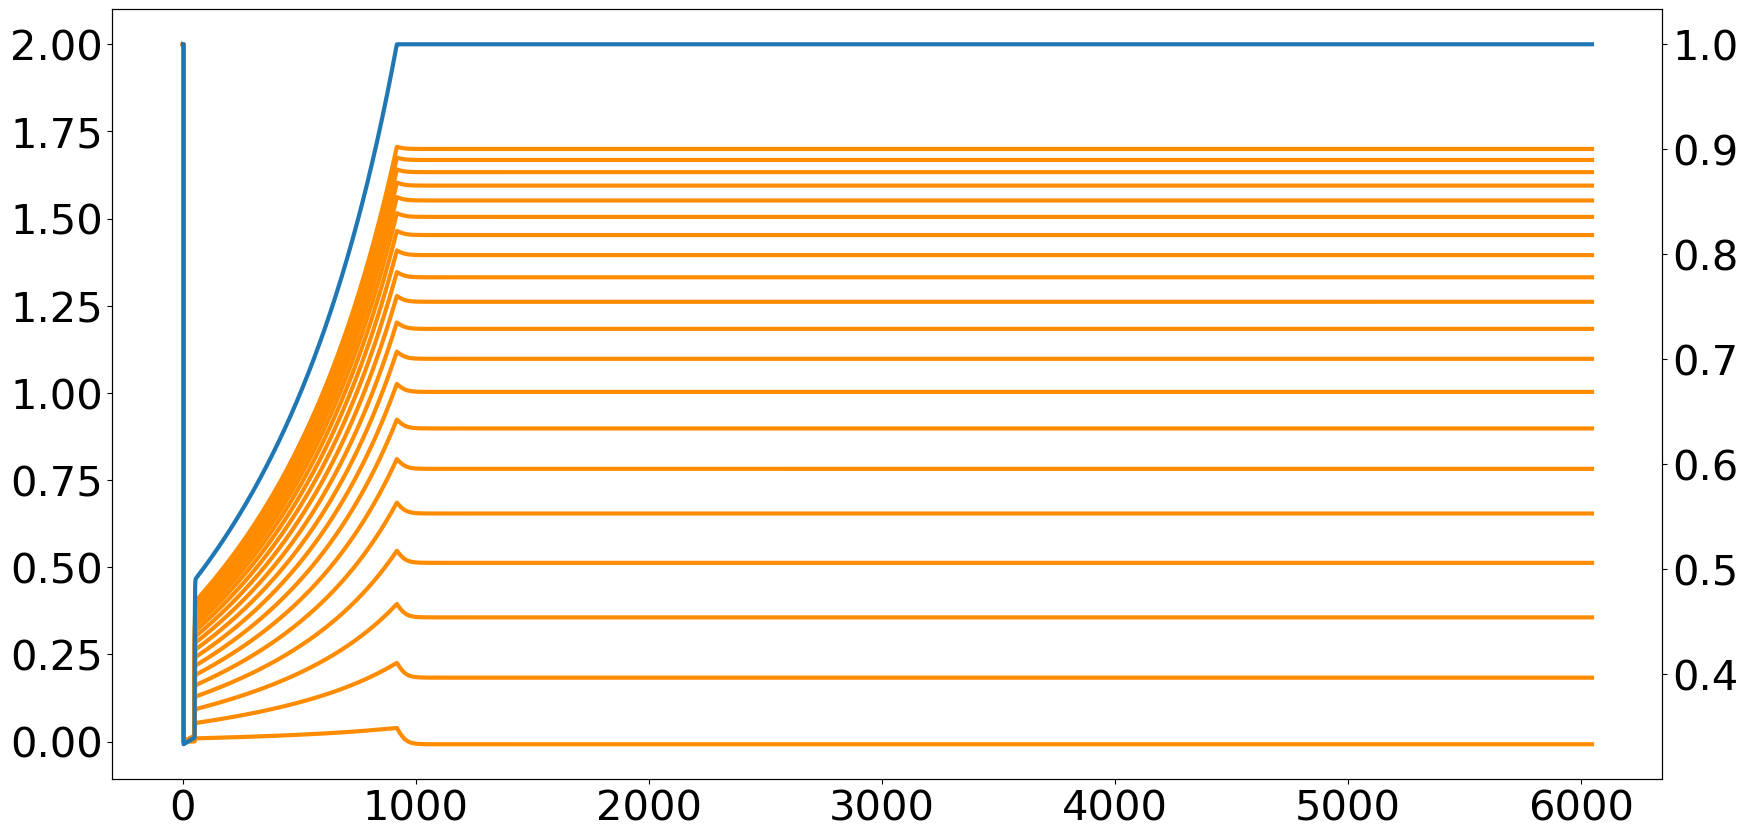

In [260]:
fig,ax= plt.subplots(1,1)
# ax.plot(ts, pi_td)
# ax.plot(ts_v0, fd)
for d in ds[::5]:
    fd = np.minimum(R0*control_fun(y,x,kappa) * ( x + (1- np.exp(-d/xi))*(z + z_v) )-1,R0-1)
    ax.plot(ts,fd,label='fd',color='darkorange')

# ax.set_yscale('log')

tax = ax.twinx()
tax.plot(ts,control_fun(y,x,kappa)  )

In [261]:
ax

<Axes: >

In [262]:
cfun[cfun==0]

array([], dtype=float64)

(-100.0, 3000.0)

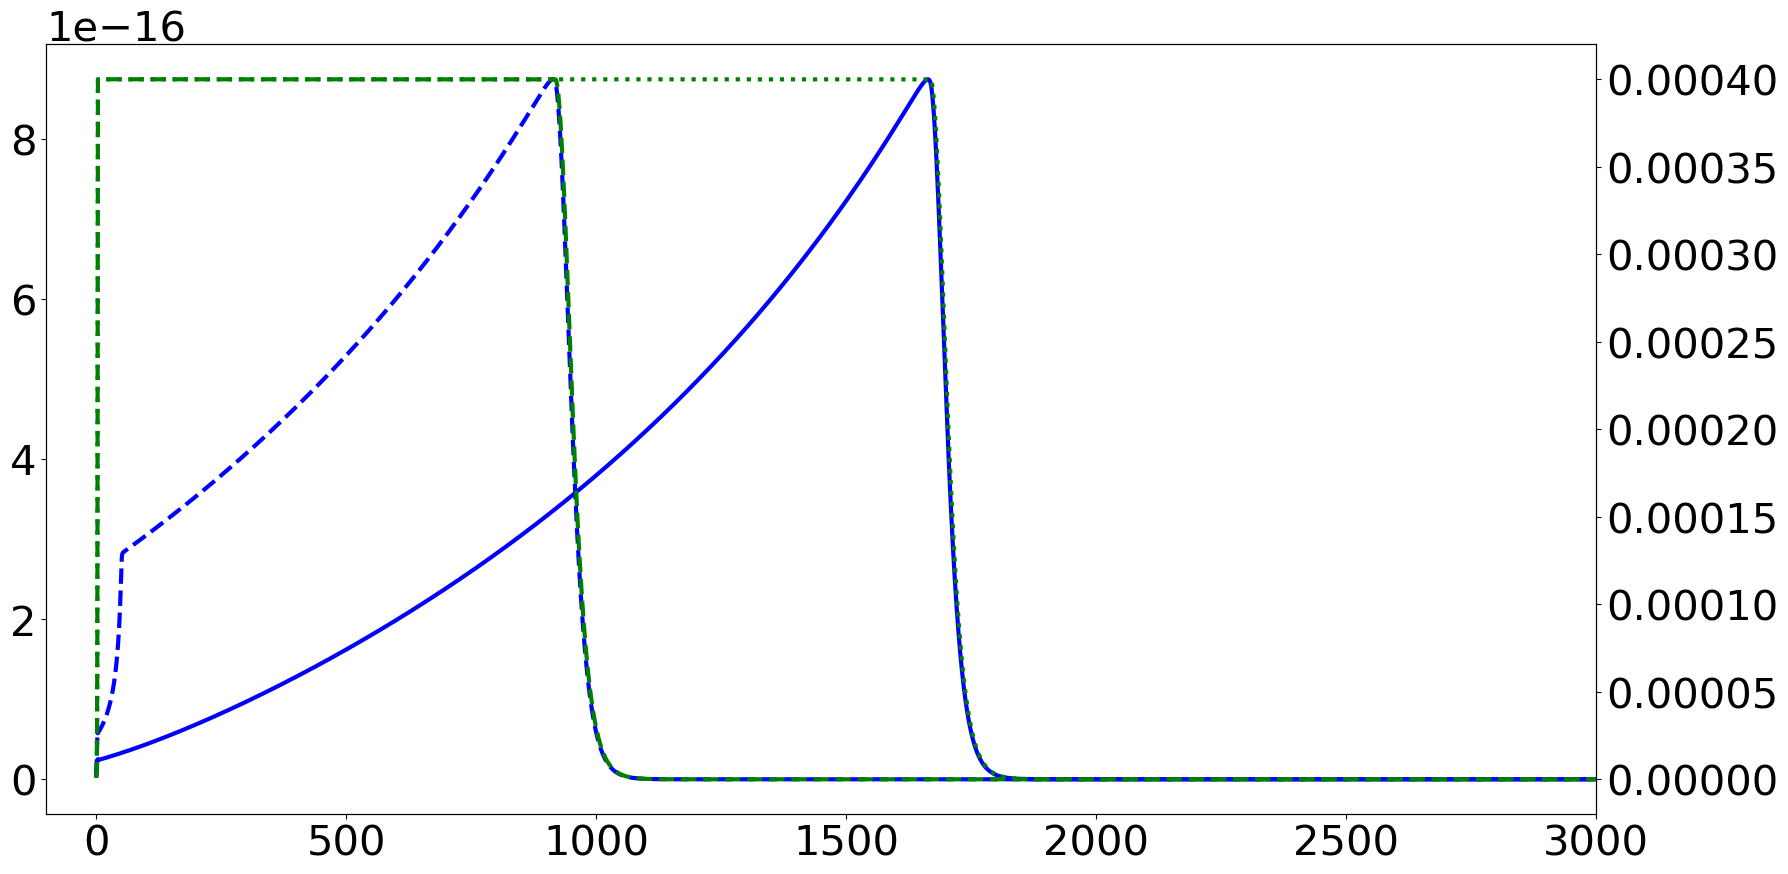

In [263]:
mu = 1e-4
N=  1e-7

fig,ax= plt.subplots(1,1,figsize=(20,10))

ax.plot(ts_v0, mu*N*y_v0*psum_v0, label='No vaccination', color='blue')
ax.plot(ts, mu*N*y*psum_v, label='Vaccination', color='blue', linestyle='--')

tax = ax.twinx()
tax.plot(ts, y, label='Vaccinated', color='green', linestyle='--')
tax.plot(ts_v0, y_v0, label='No vaccination', color='green', linestyle=':')

ax.set_xlim(-100,3000)